In [12]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

[*********************100%%**********************]  1 of 1 completed


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 90 entries, 2024-01-03 to 2024-05-10
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Close    90 non-null     float64
 1   returns  90 non-null     float64
dtypes: float64(2)
memory usage: 2.1 KB
None
                 Close   returns
Date                            
2024-01-03  784.150024 -0.020386
2024-01-04  785.950012  0.002293
2024-01-05  782.830017 -0.003978
2024-01-08  797.190002  0.018177
2024-01-09  794.520020 -0.003355


Runninng mean reversion strategy |SMA=50 & thr=2.0
fixed cost 0.0 |proportional costs 0.0
date | Buying 12 at 802.52
2024-03-15 | Current Balance 369.76
f{date} | Current net Wealth {net_wealth:.2f}
2024-03-19 | Selling 12 units at 802.30
2024-03-19 | Current Balance 9997.36
f{date} | Current net Wealth {net_wealth:.2f}
date | Buying 12 at 817.89
2024-03-20 | Current Balance 182.68
f{date} | Current net Wealth {net_wealth:.2f}
2024-03-21 | Sell

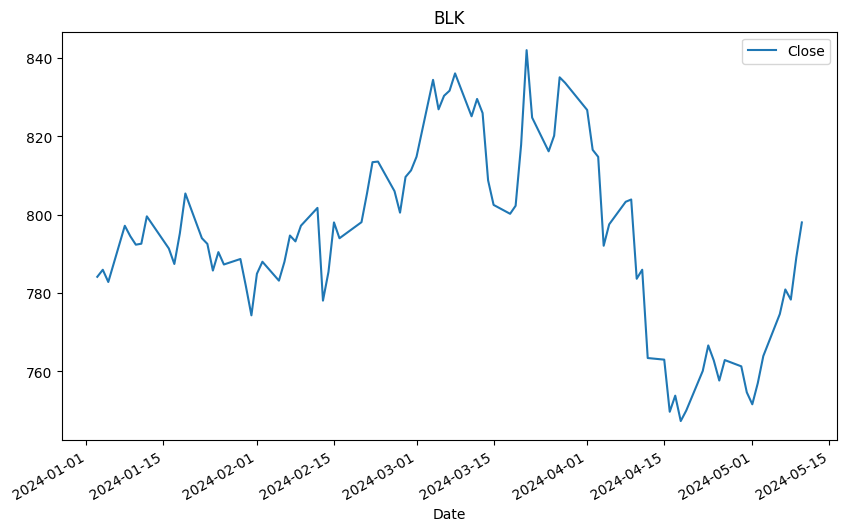

In [35]:
class backtesting:
    def __init__(self,symbols, start, end, amount, ftc=0.0, ptc=0.0, verbose=True):
       self.symbols = symbols
       self.start = start
       self.end = end
       self.units=0
       self.positions =0
       self.trades = 0
       self.initial_amount = amount
       self.amount = amount
       self.ftc = ftc
       self.ptc = ptc
       self.verbose = verbose
       self.get_data()


    def get_data(self):
        data = yf.download(self.symbols, self.start, self.end)
        raw = pd.DataFrame(data['Close'])
        raw['returns'] = np.log(raw['Close'] / raw['Close'].shift(1))
        self.data = raw.dropna()

    def plot_data(self, cols=None):

        if cols is None :
             cols = ['Close']


        self.data[cols].plot(figsize=(10, 6), title=self.symbols)

    def get_date_price(self, bar):

        date = str(self.data.index[bar])[:10]
        price = self.data['Close'][bar]
        return date, price

    def print_balance(self, bar):
        date, price = self.get_date_price(bar)
        print(f'{date} | Current Balance {self.amount:.2f}')

    def print_net_wealth(self, bar):
        date, price = self.get_date_price(bar)
        net_wealth = self.units * price + self.amount
        print('f{date} | Current net Wealth {net_wealth:.2f}')


    def place_buy_order(self, bar, units=None, amount=None):
        date , price = self.get_date_price(bar)

        if units is None :
            units = int(self.amount / price )

        self.amount -= (units * price) * (1 + self.ftc)

        self.units = units
        self.trades += 1

        if self.verbose:
           print(f'date | Buying {units} at {price:.2f}')
           self.print_balance(bar)
           self.print_net_wealth(bar)


    def place_sell_order(self, bar, units=None, amount=None):

        date, price = self.get_date_price(bar)

        if units is None :
             units = int(amount / price)

        self.amount += (units * price) * (1- self.ptc) - self.ftc

        self.units -= units
        self.trades += 1

        if self.verbose:
             print(f'{date} | Selling {units} units at {price:.2f}')
             self.print_balance(bar)
             self.print_net_wealth(bar)


    def close_out(self, bar):
        date , price = self.get_date_price(bar)

        self.amount += self.units * price

        self.units = 0

        self.trades +=1

        if self.verbose :
           print(f'{date} | inventory {self.units} units at {price: .2f}')
           print('=' * 55)
           print('Final Balance [$] {:.2f}'.format(self.amount))
           perf = ((self.amount - self.initial_amount) / self.initial_amount * 100)
           print('Net Performance [%] {:.2f}'.format(perf))
           print('Traders Executed [#] {:.2f}'.format(self.trades))
           print('=' * 55)


    def run_mean_reversion(self, SMA, threshold):


        msg = f'\n\nRunninng mean reversion strategy |'
        msg += f'SMA={SMA} & thr={threshold}'
        msg += f'\nfixed cost {self.ftc} |'
        msg += f'proportional costs {self.ptc}'
        print(msg)
        print('=' * 55)

        self.position = 0
        self.trades = 0
        self.amount = self.initial_amount

        self.data['SMA'] = self.data['Close'].rolling(SMA).mean()

        for bar in range(SMA, len(self.data)):
            if self.position == 0:
                if self.data['Close'].iloc[bar] > self.data['SMA'].iloc[bar] - threshold:

                   self.place_buy_order(bar, amount=self.amount)
                   self.position = 1

            elif self.position == 1:
                if self.data['Close'].iloc[bar] >= self.data['SMA'].iloc[bar]:

                   self.place_sell_order(bar , units=self.units)
                   self.position =0

        self.close_out(len(self.data) - 1)

if __name__ == '__main__':
   bb = backtesting('BLK', '2024-01-01', '2024-05-31', 10000)
   print(bb.data.info())
   print(bb.data.head())
   bb.run_mean_reversion(SMA=50, threshold=2.0)
   bb.plot_data()





